# Linear Regression

Sources:
  1. https://github.com/random-forests/tensorflow-workshop/blob/master/examples/01_linear_regression_low_level.ipynb
  2. https://www.tensorflow.org/get_started/mnist/pros

This notebook demonstrates linear regression in TensorFlow, and visualizes the graph and summary data for the 
variables in TensorBoard.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# A special command for IPython Notebooks that
# intructs Matplotlib to display plots in the notebook
%matplotlib inline

## Generating training and testing data

This function will create a noisy dataset that's roughly linear, according to the equation

$$
y = f(x) = \text{intercept} + \text{slope} \cdot x + \text{noise}
$$

In [2]:
def make_noisy_data(slope=0.1, intercept=0.3, n=100):
    x = np.random.rand(n).astype(np.float32)
    noise = np.random.normal(scale=0.01, size=len(x))
    y = slope * x + intercept + noise
    return x, y

Let's create data for training and testing with ``slope = 0.1`` and ``intercept = 0.3``:

In [3]:
x_train, y_train = make_noisy_data()
x_test, y_test = make_noisy_data()

We can plot our training and testing data 

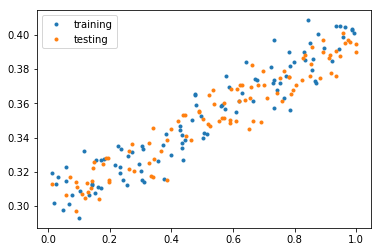

In [4]:
plt.plot(x_train, y_train, '.', label='training')
plt.plot(x_test, y_test, '.', label='testing')
plt.legend()

## Building a regression model analytically

Let's first remind us how we can obtain values for ``slope`` and ``intercept`` analytically. Given $n$ pairs $(x_i, y_i)$ as the training data, we want to solve the following system of linear equations:
$$
y_1 = \text{intercept} + \text{slope} \cdot x_1, \\
y_2 = \text{intercept} + \text{slope} \cdot x_2, \\
\vdots \\
y_n = \text{intercept} + \text{slope} \cdot x_n,
$$

In matrix form the above becomes
$$\begin{align}
(y_1, y_2, \ldots, y_n)^\top &= \text{intercept} + \text{slope} \cdot (x_1, x_2, \ldots, x_n)^\top, \\
\mathbf{y} &= b + m \cdot \mathbf{x} ,
\end{align}
$$
where $b$ denotes the intercept and $m$ the slope.

Let's denote by $\hat{b}$ and $\hat{m}$ our guess of what the intercept and slope should be. Our guess shouldn't be completely arbitrary, of course. Instead, we want to obtain a best guess. Given a value on the x-axis $x_i$, we can estimate its corresponding value on the y-axis $\hat{y}_i$ using $\hat{b}$ and $\hat{m}$ as
$$
\hat{y}_i = \hat{b} + \hat{m} \cdot x_i, 
$$
and subsequently compare it to the actual value $y_i$. One way to determine how good our guess is, is to compute the squared difference:
$$
(\hat{y}_i - y_i)^2 \Leftrightarrow (\hat{b} + \hat{m} \cdot x_i - y_i)^2  .
$$

Now, our objective is to find the best values for $\hat{b}$ and $\hat{m}$ such that $(\hat{y}_i - y_i)^2$ is minimized across all pairs $(x_i, y_i)$, or in mathematical notation
$$\begin{align}
   \hat{b}, \hat{m} &= \arg\min_{m, b} L(\hat{\mathbf{y}}, \mathbf{y}) ,\\
   L(\hat{\mathbf{y}}, \mathbf{y})
   &= \frac{1}{n} \sum_{i=1}^n (\hat{y} - y_i)^2 \\
   &= \frac{1}{n} \sum_{i=1}^n (b + m \cdot x_i - y_i)^2
\end{align}
$$
We call the function $L$ the **squared error loss**.

From calculus we remember that finding the best values for $\hat{b}$ and $\hat{m}$ can be achieved by finding the root to the first derivative of $L$ with respect to $b$ and $m$, i.e.,
$$
    \frac{d}{d~(b, m)^\top} L (\hat{\mathbf{y}}, \mathbf{y}) = 0 .
$$
Thus, the best guess is:

$$
\frac{2}{n} \begin{pmatrix}\mathbf{1} & \mathbf{x}\end{pmatrix}^\top \left[
\begin{pmatrix}\mathbf{1} & \mathbf{x}\end{pmatrix}
\begin{pmatrix}b \\ m\end{pmatrix} - \mathbf{y}
\right] = 0 \\
\begin{pmatrix}\mathbf{1} & \mathbf{x}\end{pmatrix}^\top \begin{pmatrix}\mathbf{1} & \mathbf{x}\end{pmatrix}
\begin{pmatrix}b \\ m\end{pmatrix}
= \begin{pmatrix}\mathbf{1} & \mathbf{x}\end{pmatrix}^\top \mathbf{y} \\
\begin{pmatrix}b \\ m\end{pmatrix} =
\left[ \begin{pmatrix}\mathbf{1} & \mathbf{x}\end{pmatrix}^\top \begin{pmatrix}\mathbf{1} & \mathbf{x}\end{pmatrix} \right]^{-1} 
\begin{pmatrix}\mathbf{1} & \mathbf{x}\end{pmatrix}^\top \mathbf{y}
$$

Let's compute the best estimates of the slope and intercept using just numpy.

estimated_intercept:	 0.300140679433
estimated_slope:	 0.101285420487


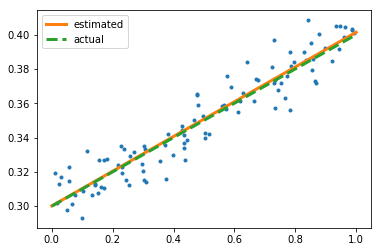

In [5]:
one_x = np.column_stack((np.ones(x_train.shape[0]), x_train))
XtX = np.dot(one_x.T, one_x)
Xy = np.dot(one_x.T, y_train)
estimated_intercept, estimated_slope = np.linalg.solve(XtX, Xy)
print("estimated_intercept:\t", estimated_intercept)
print("estimated_slope:\t", estimated_slope)

plt.plot(x_train, y_train, '.')
plt.plot([0, 1], [estimated_intercept, estimated_intercept + estimated_slope],
         lw=3, label='estimated')
plt.plot([0, 1], [0.3, 0.3 + 0.1], '--',
         lw=3, label='actual')
plt.legend()

Our estimates are very close to actual values of 0.3 and 0.1.

## Building a regression model with TensorFlow

Instead of us finding the root of the first derivative of the squared error loss, we can also formulate the minimization problem using TensorFlow and let TensorFlow find the solution without us doing any calculus.

We start by creating an empty graph and a new instance of ``tf.Session``.

In [6]:
tf.reset_default_graph()
sess = tf.Session()

### Placeholders

Next we need to build the computation graph by creating nodes for points on the x-axis and their associated values on the y-axis.

In [7]:
x_placeholder = tf.placeholder(shape=[None], dtype=tf.float32, name='x-input')
y_placeholder = tf.placeholder(shape=[None], dtype=tf.float32, name='y-input')

In [8]:
print(x_placeholder)
print(y_placeholder)

Tensor("x-input:0", shape=(?,), dtype=float32)
Tensor("y-input:0", shape=(?,), dtype=float32)


Here ``x_placeholder`` and ``y_placeholder`` aren't specific values. Rather, they are each a placeholder – a value that we'll input when we ask TensorFlow to run a computation. The input ``x_placeholder`` will consist of a 1d tensor (vector) of floating point numbers. Here we assign it a shape of ``[None]``, which indicates that the length of the input vector, corresponding to the batch size, can be of any size. The target output values ``y_placeholder`` is another 1d tensor of any size.

### Variables

We now define the slope and intercept in our linear model $y = \text{intercept} + \text{slope} \cdot x$ using ``tf.Variable``. A ``tf.Variable`` is a value that lives in TensorFlow's computation graph. It can be used and even modified by the computation. In machine learning applications, one generally has the unknown model parameters be ``Variable``s.

In [9]:
slope = tf.Variable(0.0, name='slope')
intercept = tf.Variable(0.0, name='intercept')

In [10]:
print(slope)
print(intercept)

<tf.Variable 'slope:0' shape=() dtype=float32_ref>
<tf.Variable 'intercept:0' shape=() dtype=float32_ref>


We pass the initial value for each parameter in the call to ``tf.Variable``. In this case, we initialize both ``slope`` and ``intercept`` as zero (0-dimensional tensor full of zeros).

Before ``tf.Variable``s can be used within a session, they must be initialized using that session. This step takes the initial values (in this case tensors full of zeros) that have already been specified, and assigns them to each ``tf.Variable``. This can be done for all ``tf.Variable``s at once:

In [11]:
sess.run(tf.global_variables_initializer())

### Loss function

We can now implement our regression model. It only takes one line! We multiply the input vector $x$ by the slope and add the intercept.

In [12]:
# This is the same as y = tf.add(tf.mul(slope, x_placeholder), intercept), but looks nicer
y = slope * x_placeholder + intercept

In [13]:
print(y)

Tensor("add:0", shape=(?,), dtype=float32)


We can specify a loss function just as easily. Loss indicates how bad the model's prediction was on a single example; we try to minimize that while training across all the examples. Here, our loss function is squared error loss.

In [14]:
loss = tf.reduce_mean(tf.square(y - y_placeholder))

In [15]:
print(loss)

Tensor("Mean:0", shape=(), dtype=float32)


### Training the model

Now that we have defined our model and training loss function, it is straightforward to train using TensorFlow. Because TensorFlow knows the entire computation graph, it can use automatic differentiation to find the gradients of the loss with respect to each of the variables. TensorFlow has a variety of [built-in optimization algorithms](https://www.tensorflow.org/api_guides/python/train#optimizers). For this example, we will use steepest gradient descent, with a step length of 0.5, to descend the squared error loss.

In [16]:
LEARNING_RATE = 0.5

optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)
train_step = optimizer.minimize(loss) 

What TensorFlow actually did in that single line was to add new operations to the computation graph. These operations included ones to compute gradients, compute parameter update steps, and apply update steps to the parameters.

The returned operation ``train_step``, when run, will apply the gradient descent updates to the parameters. Training the model can therefore be accomplished by repeatedly running ``train_step``.

In [17]:
TRAIN_STEPS = 201

for step in range(TRAIN_STEPS):
    sess.run(train_step,
             feed_dict={x_placeholder: x_train,
                        y_placeholder: y_train})

    # print the current estimates every 20-th step
    if step % 20 == 0:
        print(step, sess.run([slope, intercept]))

0 [0.18156771, 0.3501485]
20 [0.11155698, 0.29469928]
40 [0.10379727, 0.29881003]
60 [0.10189968, 0.29981527]
80 [0.10143563, 0.30006111]
100 [0.10132213, 0.30012122]
120 [0.10129441, 0.30013591]
140 [0.10128763, 0.30013952]
160 [0.10128596, 0.30014038]
180 [0.10128554, 0.30014062]
200 [0.10128548, 0.30014065]


We then run the ``train_step`` operation, using ``feed_dict`` to replace the placeholder tensors ``x_placeholder`` and ``y_placeholder`` with the training examples. Note that you can replace any tensor in your computation graph using ``feed_dict`` – it's not restricted to just placeholders.

Let's find out what the estimated values for intercept and slope are after training completed.

In [18]:
print ("slope: %f, intercept: %f" % (sess.run(slope), sess.run(intercept)))

slope: 0.101285, intercept: 0.300141


### Making predictions

Now that we trained our model, let's make predictions! Remember, that we use ``feed_dict`` to replace the placeholders with actual data, in this case our test data.

In [19]:
sess.run(y, feed_dict={x_placeholder: [2]})

array([ 0.50271159], dtype=float32)

Remember that ``x_placeholder`` must be a vector, hence ``[2]`` not just ``2``.
We expect the result to be (about): $0.3 + 2 \cdot 0.1 = 0.5$.

In a similar way, we can compute the mean squared error on the test data:

In [20]:
sess.run(loss, feed_dict={x_placeholder: x_test, y_placeholder: y_test})

8.2183964e-05